In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute, roll_time_series
from tsfresh.feature_extraction import EfficientFCParameters
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
#Function to load and process data 
def preprocess_data(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    col_1 = ['unit', 'time', 'op1', 'op2', 'op3']
    col_2 = [f'sr{i+1}' for i in range(21)]
    columns = col_1 + col_2
    df.columns = columns
    df['max_time'] = df.groupby('unit')['time'].transform('max')
    df['remaining_time'] = df['max_time'] - df['time']
    df['label'] = df['remaining_time'].clip(upper=130)
    return df

train_df = preprocess_data(r"C:\Users\65962\Desktop\JUPYTER\CMAPSSData\train_FD003.txt")
train_df

C:\Users\65962\AppData\Local\Temp\ipykernel_28908\4016618032.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr15,sr16,sr17,sr18,sr19,sr20,sr21,max_time,remaining_time,label
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8.4246,0.03,391,2388,100.0,39.11,23.3537,259,258,130
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8.4403,0.03,392,2388,100.0,38.99,23.4491,259,257,130
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8.3901,0.03,391,2388,100.0,38.85,23.3669,259,256,130
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8.3878,0.03,392,2388,100.0,38.96,23.2951,259,255,130
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8.3869,0.03,392,2388,100.0,39.14,23.4583,259,254,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,8.5036,0.03,394,2388,100.0,38.44,22.9631,152,4,4
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,8.5174,0.03,395,2388,100.0,38.50,22.9746,152,3,3
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,8.5223,0.03,396,2388,100.0,38.39,23.0682,152,2,2
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,8.5148,0.03,395,2388,100.0,38.31,23.0753,152,1,1


In [3]:
#summary stats
summarytrain_df=train_df.describe()
summarytrain_df

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr15,sr16,sr17,sr18,sr19,sr20,sr21,max_time,remaining_time,label
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.0,24720.00,24720.000000,24720.000000,24720.000000,2.472000e+04,...,24720.000000,2.472000e+04,24720.000000,24720.0,24720.0,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000
mean,48.631877,139.077063,-0.000024,0.000005,100.0,518.67,642.457858,1588.079175,1404.471212,1.462000e+01,...,8.396176,3.000000e-02,392.566545,2388.0,100.0,38.988552,23.393024,277.154126,138.077063,95.554207
std,29.348985,98.846675,0.002194,0.000294,0.0,0.00,0.523031,6.810418,9.773178,3.552786e-15,...,0.060512,1.734759e-17,1.761459,0.0,0.0,0.248865,0.149234,100.537886,98.846675,42.548144
min,1.000000,1.000000,-0.008600,-0.000600,100.0,518.67,640.840000,1564.300000,1377.060000,1.462000e+01,...,8.156300,3.000000e-02,388.000000,2388.0,100.0,38.170000,22.872600,145.000000,0.000000,0.000000
25%,23.000000,62.000000,-0.001500,-0.000200,100.0,518.67,642.080000,1583.280000,1397.187500,1.462000e+01,...,8.360600,3.000000e-02,391.000000,2388.0,100.0,38.830000,23.296200,197.000000,61.000000,61.000000
50%,47.000000,124.000000,-0.000000,-0.000000,100.0,518.67,642.400000,1587.520000,1402.910000,1.462000e+01,...,8.398300,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.391600,253.000000,123.000000,123.000000
75%,74.000000,191.000000,0.001500,0.000300,100.0,518.67,642.790000,1592.412500,1410.600000,1.462000e+01,...,8.437000,3.000000e-02,394.000000,2388.0,100.0,39.140000,23.483300,324.000000,190.000000,130.000000
max,100.000000,525.000000,0.008600,0.000700,100.0,518.67,645.110000,1615.390000,1441.160000,1.462000e+01,...,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500,525.000000,524.000000,130.000000


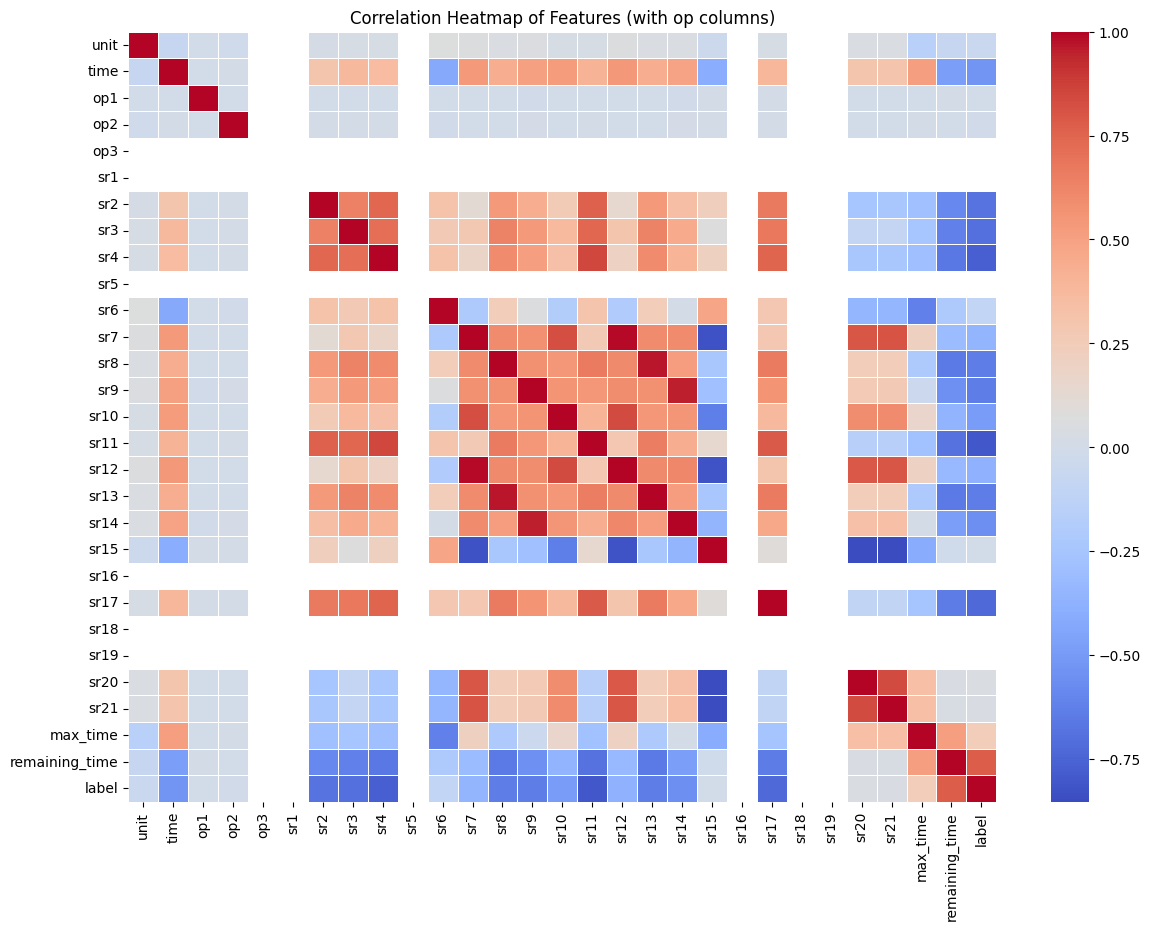

In [4]:
#correlation heatmap
plt.figure(figsize=(14,10))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features (with op columns)')
plt.show()

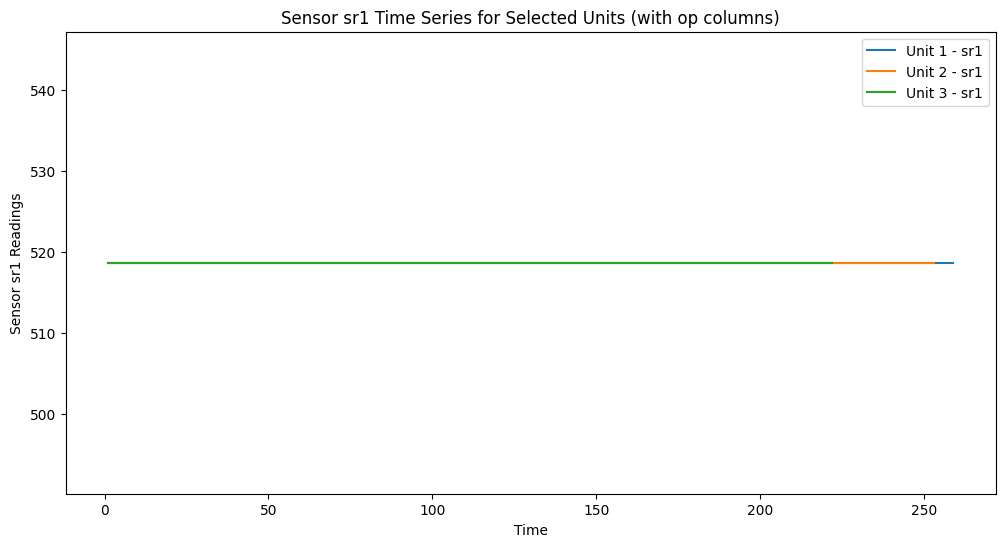

In [5]:
#time series data plots 
sample_units = train_df['unit'].unique()[:3]

plt.figure(figsize=(12, 6))
for unit in sample_units:
    unit_data = train_df[train_df['unit'] == unit]
    plt.plot(unit_data['time'], unit_data['sr1'], label=f'Unit {unit} - sr1')
    
plt.title('Sensor sr1 Time Series for Selected Units (with op columns)')
plt.xlabel('Time')
plt.ylabel('Sensor sr1 Readings')
plt.legend()
plt.show()

In [6]:
##feature extraction here 
#window size 
window_size = 30
rolled_train = roll_time_series(train_df,
                                column_id='unit',
                                column_sort='time',
                                max_timeshift=window_size - 1,
                                min_timeshift=window_size - 1,
                                rolling_direction=1)

#selecting operational & sensor cols
selected_cols_with_op = ['unit', 'op1', 'op2', 'op3'] + [f'sr{i+1}' for i in range(21)]
selected_train = rolled_train[selected_cols_with_op]

Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  7.19it/s]


In [15]:
extraction_settings = EfficientFCParameters()

# Extract features using TSFRESH
X_train_features_with_op = extract_features(selected_train,
                                            column_id='unit',
                                            impute_function=impute,
                                            default_fc_parameters=extraction_settings)

# Extract labels
y_train_with_op = rolled_train.groupby('unit')['label'].last()

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [04:34<00:00,  6.86s/it]


In [23]:
print(X_train_features_with_op.head())

   op1__variance_larger_than_standard_deviation  op1__has_duplicate_max  \
1                                           0.0                     1.0   
2                                           0.0                     1.0   
3                                           0.0                     1.0   
4                                           0.0                     1.0   
5                                           0.0                     1.0   

   op1__has_duplicate_min  op1__has_duplicate  op1__sum_values  \
1                     1.0                 1.0           0.7357   
2                     1.0                 1.0           0.8273   
3                     1.0                 1.0           1.1148   
4                     1.0                 1.0          -0.3578   
5                     1.0                 1.0           0.4141   

   op1__abs_energy  op1__mean_abs_change  op1__mean_change  \
1         0.038637              0.002611      6.957530e-07   
2         0.036493          

In [24]:
#scaling
scaler= StandardScaler()
X_train_scale= scaler.fit_transform(X_train_features_with_op)

#split data 
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scale, y_train_with_op, test_size=0.2, random_state=42)

#train model
xgb_model_with_op = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model_with_op.fit(X_train_split, y_train_split)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [25]:
#evaluate and predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_val_pred_with_op = xgb_model_with_op.predict(X_val_split)

mse_with_op = mean_squared_error(y_val_split, y_val_pred_with_op)
print(mse_with_op)

rmse_with_op = mse_with_op ** 0.5
print(rmse_with_op)

mae_with_op = mean_absolute_error(y_val_split, y_val_pred_with_op)
print(mae_with_op)

r2_with_op = r2_score(y_val_split, y_val_pred_with_op)
print(r2_with_op)

0.0
0.0
0.0
1.0


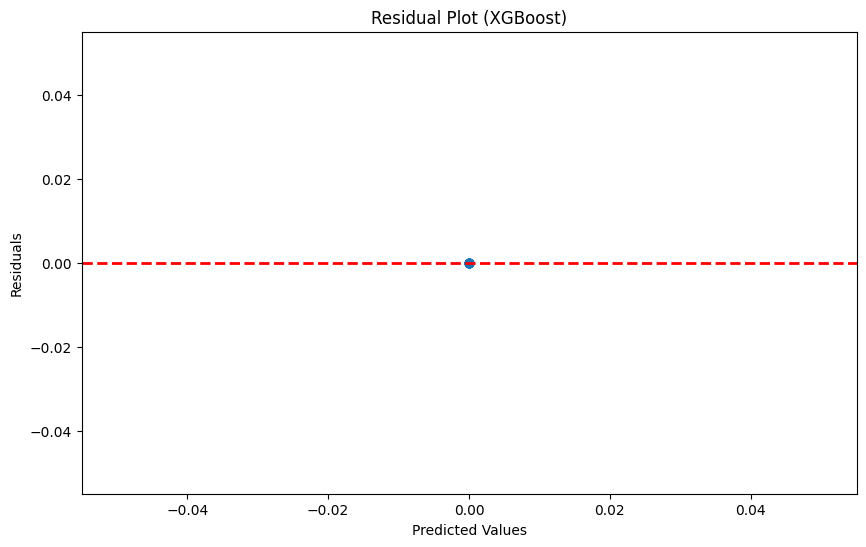

In [26]:
#calculate residuals 
residuals=y_val_split-y_val_pred_with_op

#plot residuals against predicated values 
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred_with_op, residuals)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost)')
plt.show()